## Import

In [93]:
from skimage import color, io, img_as_float
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu

import re
from pathlib import Path
import math
from itertools import product
from collections import deque
import copy

## Fungsi

In [198]:
#Fungsi menampilkan gambar
def imgshow(input, msg=''):
  plt.imshow(input, cmap='gray')
  plt.title(msg)
  plt.grid()
  plt.show()

def imgshow1(input, msg=''):
  plt.imshow(input, cmap='gray')
  plt.title(msg)
  plt.grid()

  #vertical line pada plot
  plt.axvline(x=10, color='red', linewidth=1)
  plt.axvline(x=115, color='red', linewidth=1)
  plt.axvline(x=145, color='red', linewidth=1)
  plt.axvline(x=245, color='red', linewidth=1)

  #horizontal line pada plot
  plt.axhline(y=15, color='red', linewidth=1)
  # plt.axhline(y=240, color='red', linewidth=1)
  plt.show()



# k = 3
# kernel = np.ones((k,k),np.uint8)
kernel1 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
kernel3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(9,9))

#Fungsi CLAHE
def clahe(input, clipLimit=5.0, tileGridSize=(2,2)):
  #CLAHE object (arguments are optional).
  clahe = cv.createCLAHE(clipLimit, tileGridSize)
  # clahe = cv.createCLAHE(clipLimit=20.0, tileGridSize=(2,2))
  # clahe = cv.createCLAHE(clipLimit=5.0, tileGridSize=(2,2))
  output = clahe.apply(input)

  return output

#Fungsi Region Growing Multi-seed
def rg_corner(input, T=20):

    gray = input  # diasumsikan grayscale uint8
    h, w = gray.shape
    seed_points = [(5,5),(h-5,5),(5,w-5),(h-5,w-5)]
    final_mask = np.zeros((h, w), dtype=np.uint8)

    # --- region growing untuk satu seed ---
    def region_growing(img, seed, T):
        H, W = img.shape
        region  = np.zeros((H, W), dtype=bool)
        visited = np.zeros((H, W), dtype=bool)

        # 8-neighbors
        neighbors = [(-1,-1), (-1,0), (-1,1),
                     ( 0,-1),        ( 0,1),
                     ( 1,-1), ( 1,0), ( 1,1)]

        q = deque([seed])
        sy, sx = seed
        seed_val = int(img[sy, sx])
        visited[sy, sx] = True

        while q:
            y, x = q.popleft()
            region[y, x] = True

            for dy, dx in neighbors:
                ny, nx = y + dy, x + dx
                if 0 <= ny < H and 0 <= nx < W and not visited[ny, nx]:
                    pix_val = int(img[ny, nx])
                    if abs(pix_val - seed_val) <= T:
                        q.append((ny, nx))
                    visited[ny, nx] = True

        return (region.astype(np.uint8)) * 255
    
    # Kumpulkan seed yang ingin dihapus
    to_remove = []

    for seed in seed_points:
      if gray[seed] > 50:
        to_remove.append(seed)

    # Hapus semua sekaligus
    for s in to_remove:
      seed_points.remove(s)

    # --- gabungkan hasil semua seed ---
    for seed in seed_points:
      mask = region_growing(gray, seed, T)
          
      final_mask = cv.bitwise_or(final_mask, mask)

    #Visualisasi hasil
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.title("Input")
    plt.imshow(gray, cmap='gray')
    for s in seed_points:
        plt.scatter(s[1], s[0], c='red', s=40, marker='x')

    plt.subplot(1,2,2)
    plt.title(f"Hasil Region Growing (T={T})")
    plt.imshow(final_mask, cmap='gray')
    plt.show()

    return final_mask

#Fungsi Otsu
def otsu(input,t1=0,t2=255):
   ret, output = cv.threshold(input,t1,t2,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

   return ret, output

#Fungsi CCA
def cca(input, connectivity=8):
  # CCA
  num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(input, connectivity=8)

  # Ambil area setiap komponen, skip index 0 (background)
  areas = stats[1:, cv.CC_STAT_AREA]

  # Ambil 2 komponen terbesar
  largest_two = np.argsort(areas)[-2:]   # index relatif terhadap stats[1:]
                                          
  # Buat mask baru kosong
  cca_mask = np.zeros_like(input)

  # Isi mask dengan dua komponen terbesar
  for idx in largest_two:
    cca_mask[labels == (idx + 1)] = 255

  return cca_mask

#Fungsi Convex Hull
def convex_hull(input):

  num_255 = np.sum(input == 255)
  num_0 = np.sum(input == 0)
  print(num_255, num_0)

  if num_255 < num_0:
    contours, _ = cv.findContours(input, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    hull_mask = np.zeros_like(input)

    for cnt in contours:
      hull = cv.convexHull(cnt)
      cv.drawContours(hull_mask, [hull], -1, 255, -1)
  else:
    hull_mask = input

  return hull_mask

## Input Citra

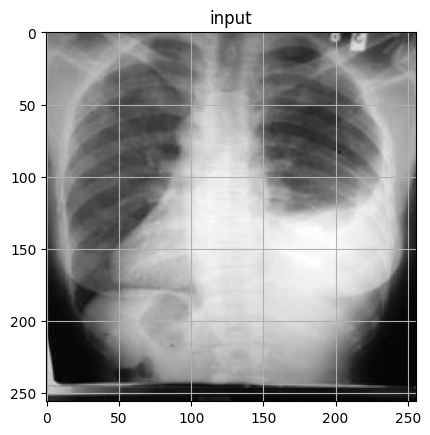

In [199]:
# path = ["Dataset X-rays/Normal/others (1).jpg"] #path img Normal 
path = ["Dataset X-rays/TB/TB.6.jpg"] #path img TB
img = []

for i in path:
  image = cv.imread(i, cv.IMREAD_GRAYSCALE)
  img.append(image)

for i in img:
  imgshow(i,"input")

## ESFERM

### Enchance

#### CLAHE

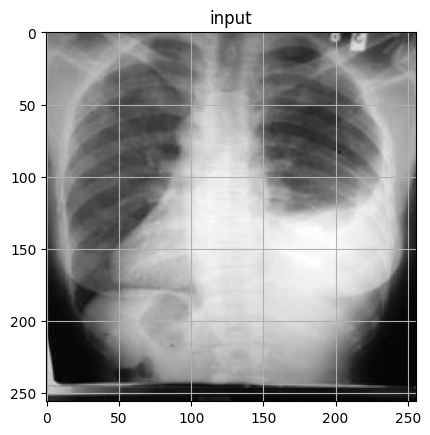

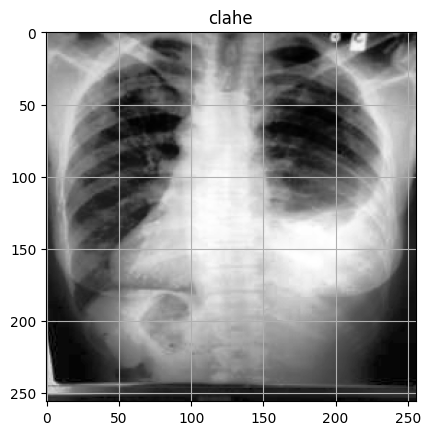

In [200]:
#CLAHE
out_clahe = clahe(img[0]) 
imgshow(img[0],"input")
imgshow(out_clahe,"clahe")

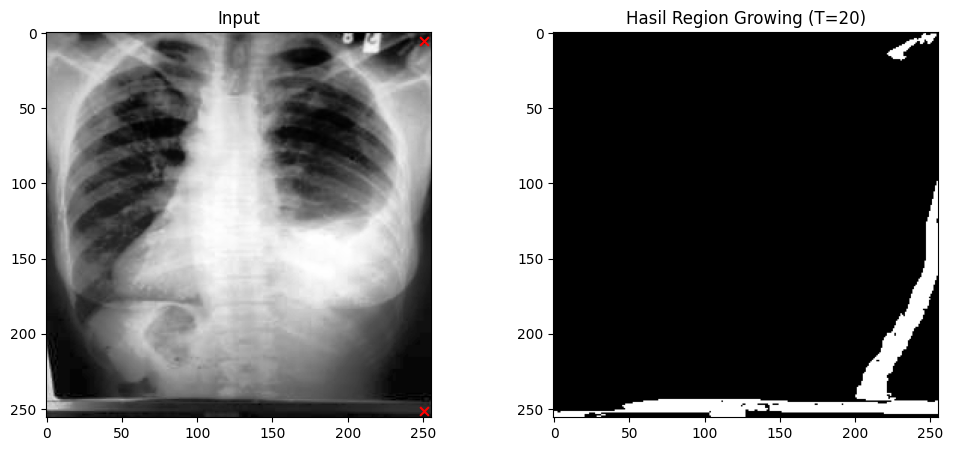

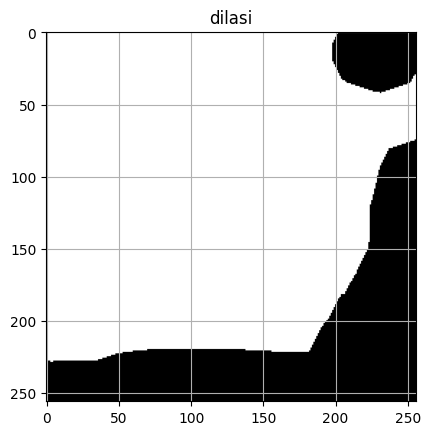

In [201]:
# corner = rg_corner(img[0])
corner = rg_corner(out_clahe)
# imgshow(output, "Region Growing Multi-seed")

#dilasi
corner = cv.dilate(corner,kernel3,iterations = 6)
corner = cv.bitwise_not(corner)
imgshow(corner,'dilasi')

### Segmentasi 

#### Otsu


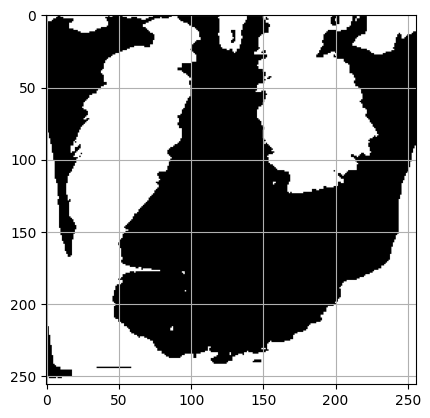

In [203]:
# _, otsu = cv.threshold(cl,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
_, out_otsu = otsu(out_clahe)
# _, out_otsu = otsu(clean)

imgshow(out_otsu)

# _, otsu1 = cv.threshold(cl, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
# _, biner = cv.threshold(cl, 100, 255, cv.THRESH_BINARY_INV)

# imgshow(otsu1,'otsu th')
# imgshow(biner,'biner th')

#### Morfologi dan Connected component

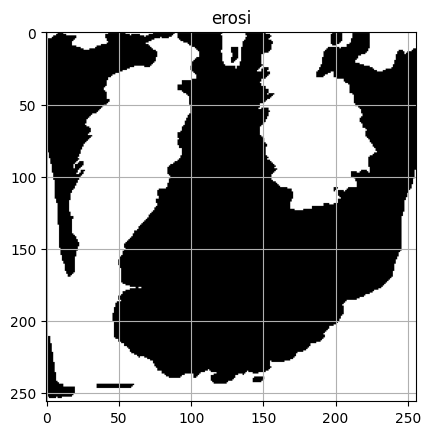

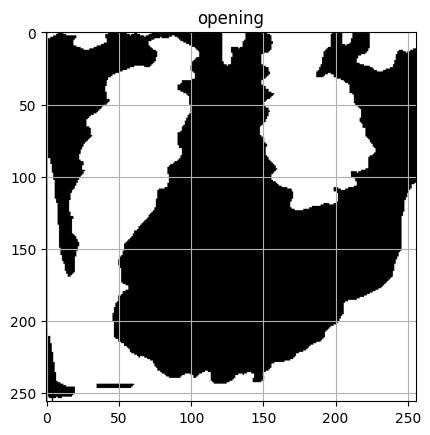

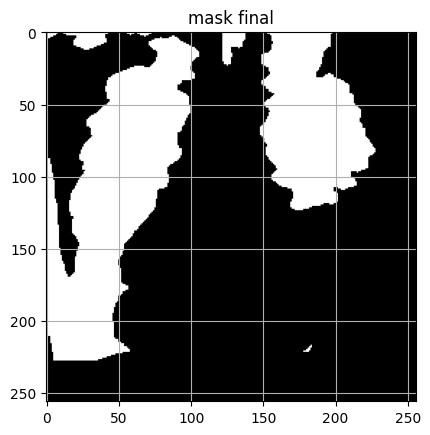

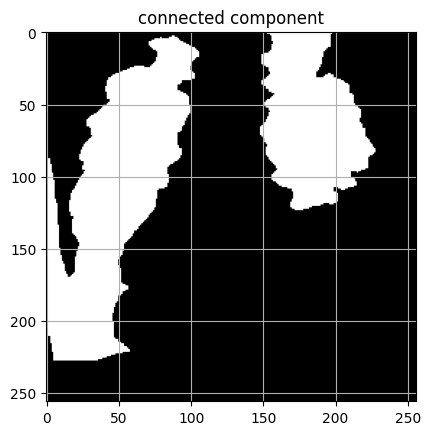

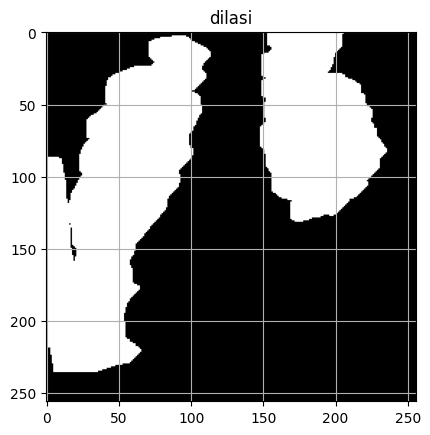

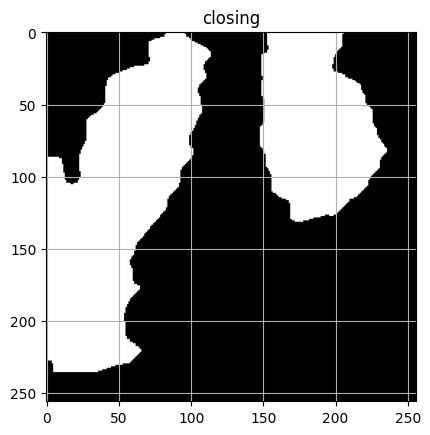

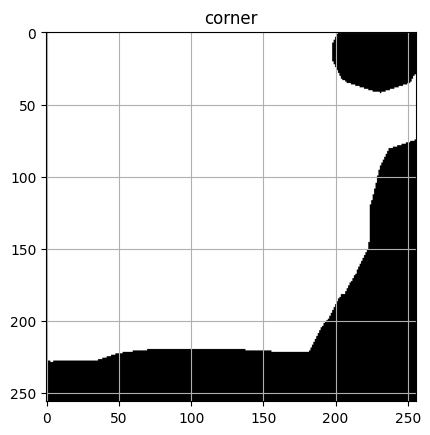

In [204]:
# k = 3
# kernel = np.ones((k,k),np.uint8)
kernel1 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
kernel3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(9,9))

#erosi
morf = cv.erode(out_otsu,kernel1,iterations = 2)
imgshow(morf,'erosi')

#opening
morf = cv.morphologyEx(morf, cv.MORPH_OPEN, kernel2)
imgshow(morf,'opening')

#masking
morf = cv.bitwise_and(corner, morf)
imgshow(morf,'mask final')

#CCA
out_cca = cca(morf)
imgshow(out_cca,'connected component')

#dilasi
morf = cv.dilate(out_cca,kernel1,iterations = 8)
imgshow(morf,'dilasi')

# #closing
morf = cv.morphologyEx(morf, cv.MORPH_CLOSE, kernel3)
imgshow(morf,'closing')

imgshow(corner,'corner')


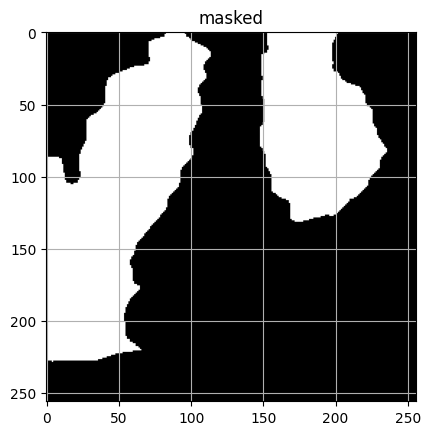

In [205]:
morf = cv.bitwise_and(corner, morf)
imgshow(morf,'masked')

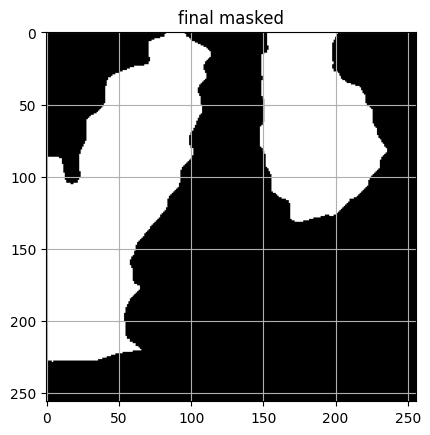

In [206]:
morf = cca(morf)
imgshow(morf,'final masked')

22860 42676


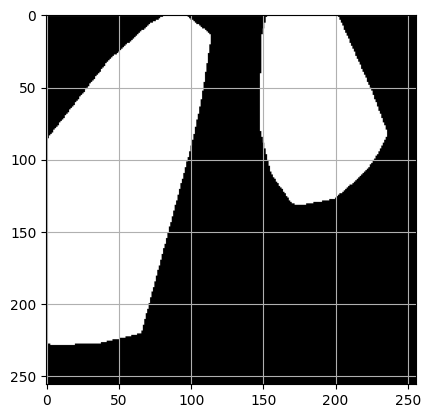

In [207]:
out_hull = convex_hull(morf)
imgshow(out_hull)

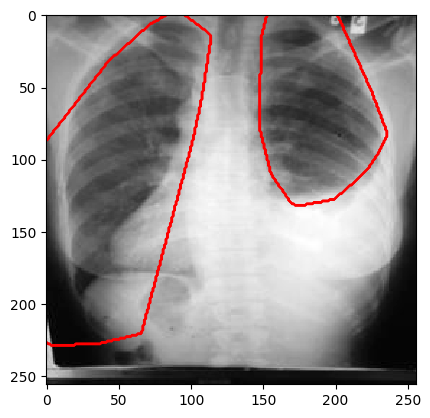

In [208]:
plt.imshow(img[0], 'gray', interpolation='none')
plt.contour(out_hull,colors='red',linewidths=1)
# plt.imshow(out_hull, 'Greens', interpolation='none', alpha=0.4)
# plt.savefig("hasil_overlay.png", dpi=300, bbox_inches='tight')
plt.show()

### Fitur

In [ ]:
# ===============================
# 1. GLCM MANUAL
# ===============================
def compute_glcm(img, d=1, angle=0, levels=8):
    """
    Hitung GLCM untuk 1 arah & jarak tertentu.
    angle: 0 (horizontal), 90, 45, 135.
    """
    H, W = img.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    # arah
    if angle == 0:      # kanan
        dx, dy = d, 0
    elif angle == 90:   # bawah
        dx, dy = 0, d
    elif angle == 45:   # kanan atas
        dx, dy = d, -d
    elif angle == 135:  # kiri bawah
        dx, dy = -d, d
    else:
        raise ValueError("Angle harus 0, 45, 90, atau 135")

    for y in range(H):
        for x in range(W):
            nx, ny = x+dx, y+dy
            if 0 <= nx < W and 0 <= ny < H:
                i = img[y, x]
                j = img[ny, nx]
                glcm[i, j] += 1

    # normalisasi ke probabilitas
    if glcm.sum() > 0:
        glcm /= glcm.sum()
    return glcm


def glcm_features(glcm):
    """Hitung contrast, energy, homogeneity, entropy dari 1 GLCM"""
    contrast = 0
    energy = np.sum(glcm**2)
    homogeneity = 0
    entropy = 0

    levels = glcm.shape[0]
    for i in range(levels):
        for j in range(levels):
            contrast += (i-j)**2 * glcm[i,j]
            homogeneity += glcm[i,j] / (1 + abs(i-j))
            if glcm[i,j] > 0:
                entropy -= glcm[i,j] * np.log2(glcm[i,j])

    return [contrast, energy, homogeneity, entropy]


def compute_glcm_multi(img, levels=8):
    """Hitung GLCM fitur rata-rata dari 4 arah"""
    angles = [0, 45, 90, 135]
    feats = []
    for a in angles:
        glcm = compute_glcm(img, d=1, angle=a, levels=levels)
        feats.append(glcm_features(glcm))
    return np.mean(feats, axis=0)   # rata-rata semua arah


# ===============================
# 2. LBP MANUAL
# ===============================
def compute_lbp(img, P=8, R=1):
    H, W = img.shape
    lbp = np.zeros_like(img, dtype=np.uint8)

    for y in range(R, H-R):
        for x in range(R, W-R):
            center = img[y, x]
            code = 0
            for p in range(P):
                theta = 2*np.pi*p / P
                xp = int(x + R*np.cos(theta))
                yp = int(y - R*np.sin(theta))
                code <<= 1
                if img[yp, xp] >= center:
                    code |= 1
            lbp[y, x] = code
    return lbp


def lbp_features(lbp, bins=16):
    hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0,256), density=True)
    return hist.tolist()


# ===============================
# 3. INTENSITY FEATURES
# ===============================
def intensity_features(img):
    return [np.mean(img), np.std(img)]


# ===============================
# 4. FULL FEATURE EXTRACTOR
# ===============================
def extract_features(img, mask=None, levels=8):
    """
    Ekstrak fitur GLCM + LBP + Intensity.
    img: sudah grayscale [0..255]
    mask: binary mask (1=paru, 0=luar), optional
    """
    # apply mask kalau ada
    if mask is not None:
        img = img * mask

    # normalisasi ke [0, levels-1]
    img_q = np.floor(img / (256/levels)).astype(np.uint8)

    # GLCM
    glcm_feat = compute_glcm_multi(img_q, levels=levels)

    # LBP
    lbp_img = compute_lbp(img_q)
    lbp_feat = lbp_features(lbp_img)

    # Intensity
    int_feat = intensity_features(img_q)

    # Gabungan semua
    return np.array(glcm_feat + lbp_feat + int_feat)


In [ ]:
def extract_features(img, lung_mask):
  """
  Ekstraksi fitur dari ROI paru:
  - Intensity (mean, std, entropy)
  - GLCM (contrast, energy, homogeneity, correlation)
  - LBP histogram
  """
  import math

  # Masking paru
  roi = img * lung_mask
  roi_vals = roi[lung_mask > 0]

  # === Intensity features ===
  mean_int = np.mean(roi_vals)
  std_int = np.std(roi_vals)
  hist, _ = np.histogram(roi_vals, bins=256, range=(0,256))
  p_hist = hist / (hist.sum() + 1e-6)
  entropy = -np.sum(p_hist * np.log2(p_hist + 1e-6))

  # === GLCM features ===
  glcm = compute_glcm(roi, distances=[1], angles=[0])  # dari kode GLCM sebelumnya
  contrast = compute_glcm_feature(glcm, "contrast")
  energy   = compute_glcm_feature(glcm, "energy")
  homogeneity = compute_glcm_feature(glcm, "homogeneity")
  correlation = compute_glcm_feature(glcm, "correlation")

  # === LBP features ===
  lbp_img = lbp_basic(roi)
  lbp_feat = lbp_hist(lbp_img, bins=256)  # panjang 256

  # === Gabungan ===
  features = np.hstack([
      [mean_int, std_int, entropy, contrast, energy, homogeneity, correlation],
      lbp_feat
  ])

  return features
